# Project 4b - Image Warping and Mosaicing

### Dependencies

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
from harris import get_harris_corners, dist2
from scipy.ndimage import distance_transform_edt

## Interest Point Detector

In [2]:
# Load images and points
image_left = plt.imread('../data/IMG_8405.jpeg')
image_right = plt.imread('../data/IMG_8406.jpeg')

# make panoramal left b&w
image_left_gray = np.mean(image_left, axis=2)
image_right_gray = np.mean(image_right, axis=2)

h_left, coords_left = get_harris_corners(image_left_gray)
h_right, coords_right = get_harris_corners(image_right_gray)

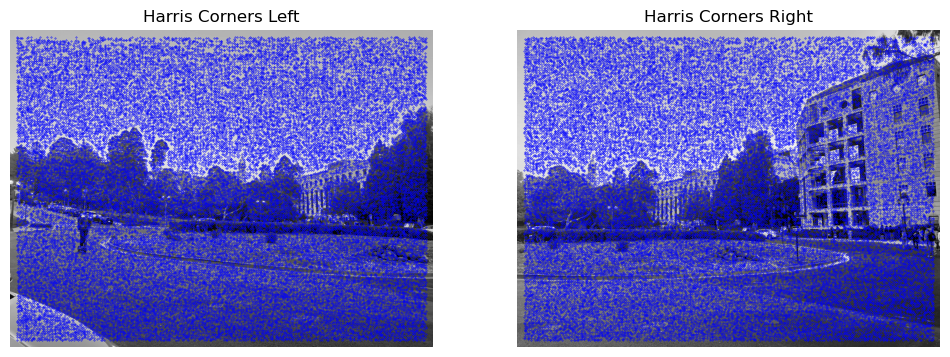

In [3]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Display Harris corners for the left image
plt.subplot(1, 2, 1)
plt.imshow(image_left_gray, cmap='gray')
plt.scatter(coords_left[1], coords_left[0], c='b', s=0.1)
plt.title('Harris Corners Left')
plt.axis('off')

# Display Harris corners for the right image
plt.subplot(1, 2, 2)
plt.imshow(image_right_gray, cmap='gray')
plt.scatter(coords_right[1], coords_right[0], c='b', s=0.1)
plt.title('Harris Corners Right')
plt.axis('off')

plt.show()

## Adaptive Non-Maximal Suppression

In [4]:
def adaptive_non_maximal_suppression(corners, h, num_points=500, c_robust=0.9):
    """
    Adaptive Non-Maximal Suppression following the approach outlined.
    
    :param corners: (2, n) array of corner coordinates (ys, xs).
    :param h: Harris response values of the image.
    :param num_points: Number of points to retain after ANMS.
    :param c_robust: Constant used in suppression condition (default = 0.9).
    :return: Array of suppressed corner coordinates.
    """
    # Extract Harris strengths for each corner point
    scores = h[corners[0], corners[1]]
    
    # Calculate pairwise distances between all corners using dist2()
    dists = dist2(corners.T, corners.T)  # corners.T is of shape (n, 2)
    
    # Broadcast comparison: f(x_i) < c_robust * f(x_j)
    larger_mask = scores[:, np.newaxis] < (c_robust * scores[np.newaxis, :])
    
    # Mask the distances where the comparison holds and set the rest to infinity
    masked_dists = np.where(larger_mask, dists, np.inf)
    
    # Calculate the minimum radius for each point
    radii = np.min(masked_dists, axis=1)
    
    # Sort points by their radii in descending order
    sorted_indices = np.argsort(-radii)
    
    # Sort the original corners based on radii
    sorted_corners = corners[:, sorted_indices]
    
    # Return the top 'num_points' corners
    return sorted_corners[:, :num_points]

# Apply Adaptive Non-Maximal Suppression to get top corners
suppressed_coords_left = adaptive_non_maximal_suppression(coords_left, h_left)
suppressed_coords_right = adaptive_non_maximal_suppression(coords_right, h_right)

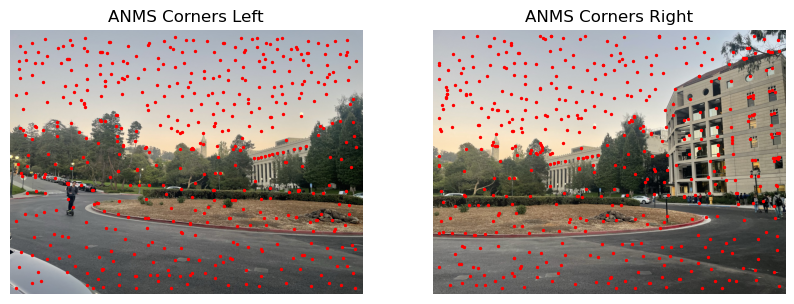

In [5]:
# Display ANMS corners
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(image_left, cmap='gray')
plt.scatter(suppressed_coords_left[1], suppressed_coords_left[0], c='r', s=2)
plt.title('ANMS Corners Left')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(image_right, cmap='gray')
plt.scatter(suppressed_coords_right[1], suppressed_coords_right[0], c='r', s=2)
plt.title('ANMS Corners Right')
plt.axis('off')

plt.show()

## Feature Descriptor Extraction

In [6]:
# Redo
def extract_feature_descriptors(im, coords, patch_size=8, window_size=40, spacing=5):
    """
    Extracts bias/gain-normalized 8x8 color feature descriptors from a larger 40x40 window 
    around each interest point for each of the three color channels (R, G, B).
    
    Parameters:
    im (HxWx3 array): Colored image (RGB) from which to extract features.
    coords (2xN array): Coordinates of interest points (ys, xs).
    patch_size (int): Size of the descriptor patch (default is 8x8).
    window_size (int): Size of the larger window from which the 8x8 patch is sampled (default is 40x40).
    spacing (int): Pixel spacing between samples for the 8x8 patch (default is 5).
    
    Returns:
    descriptors (N x 192 array): Normalized color feature descriptors for each interest point.
    """
    half_window = window_size // 2
    half_patch = patch_size // 2
    descriptors = []

    # Loop over each point
    for y, x in coords.T:
        # Check for edge cases (skip points near the edges)
        if (y - half_window < 0 or y + half_window >= im.shape[0] or 
            x - half_window < 0 or x + half_window >= im.shape[1]):
            continue

        # Initialize an empty list to store the descriptor for each channel
        descriptor_channels = []
        
        # Loop over each channel (R, G, B)
        for channel in range(3):
            # Extract the 40x40 window for the current channel
            window = im[y-half_window:y+half_window, x-half_window:x+half_window, channel]

            # Blur the window to reduce aliasing
            window = gaussian_filter(window, sigma=1)

            # Sample an 8x8 patch from the window with spacing
            patch = window[::spacing, ::spacing][:patch_size, :patch_size]

            # Normalize the patch (bias/gain normalization)
            patch_mean = np.mean(patch)
            patch_std = np.std(patch)
            if patch_std > 0:
                patch = (patch - patch_mean) / patch_std

            # Flatten the patch into a vector and store it
            descriptor_channels.append(patch.flatten())

        # Concatenate descriptors from all three channels to form a single vector
        descriptor = np.concatenate(descriptor_channels)
        descriptors.append(descriptor)

    return np.array(descriptors)

descriptors_left = extract_feature_descriptors(image_left, suppressed_coords_left)
descriptors_right = extract_feature_descriptors(image_right, suppressed_coords_right)

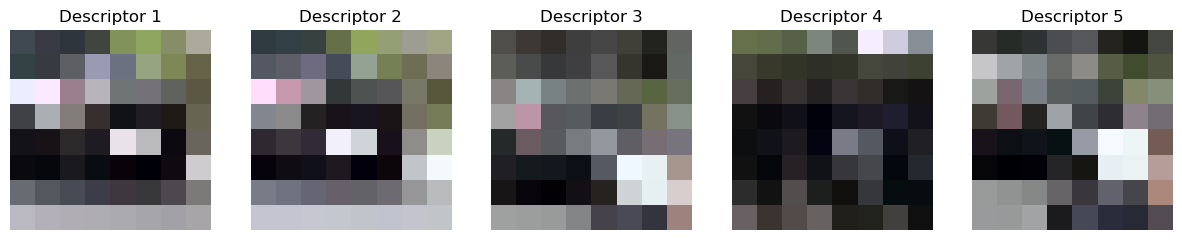

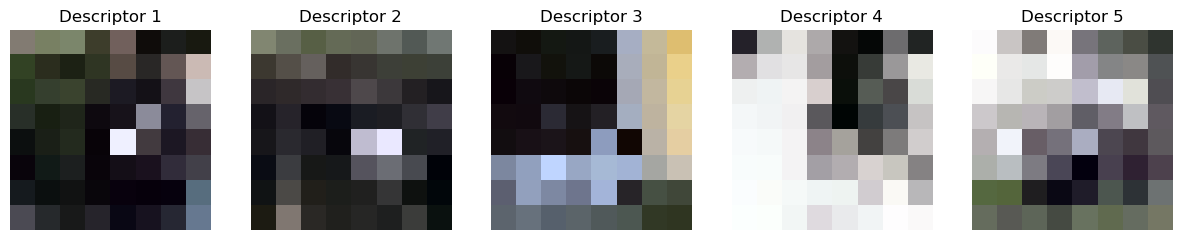

In [7]:
# Redo
def visualize_descriptors(descriptors, num_descriptors=5, patch_size=8):
    """
    Visualizes the first few descriptors as RGB images.
    
    Parameters:
    descriptors (N x 192 array): Color feature descriptors.
    num_descriptors (int): Number of descriptors to visualize (default is 5).
    patch_size (int): Size of the descriptor patch (default is 8x8).
    """
    fig, axes = plt.subplots(1, num_descriptors, figsize=(15, 5))
    
    for i in range(num_descriptors):
        descriptor = descriptors[i]
        
        # Reshape the descriptor into three 8x8 patches for R, G, B channels
        patch_r = descriptor[:patch_size*patch_size].reshape((patch_size, patch_size))
        patch_g = descriptor[patch_size*patch_size:2*patch_size*patch_size].reshape((patch_size, patch_size))
        patch_b = descriptor[2*patch_size*patch_size:].reshape((patch_size, patch_size))
        
        # Combine the patches into a single 8x8x3 RGB image
        patch_rgb = np.stack((patch_r, patch_g, patch_b), axis=-1)
        
        # Normalize the RGB image to [0, 1] for visualization
        patch_rgb = (patch_rgb - patch_rgb.min()) / (patch_rgb.max() - patch_rgb.min())
        
        # Display the RGB image
        axes[i].imshow(patch_rgb)
        axes[i].axis('off')
        axes[i].set_title(f'Descriptor {i+1}')
    
    plt.show()

visualize_descriptors(descriptors_left, num_descriptors=5)
visualize_descriptors(descriptors_right, num_descriptors=5)

## Feature Matching

In [8]:
# Redo
def match_features(descriptors1, descriptors2, ratio_threshold=0.8):
    """
    Matches color feature descriptors from two sets using Lowe's ratio test, enforcing one-to-one matching.
    
    Parameters:
    descriptors1 (N1 x 192 array): Color feature descriptors from the first image.
    descriptors2 (N2 x 192 array): Color feature descriptors from the second image.
    ratio_threshold (float): Threshold for Lowe's ratio test (default is 0.8).
    
    Returns:
    matches (list of tuples): List of matching descriptor pairs (i, j) where 
                              i is the index of the descriptor in descriptors1 and
                              j is the index of the descriptor in descriptors2.
    """
    
    matches = []
    matched_in_second_image = set()  # Track points already matched in the second image
    
    # Loop over descriptors in the first image
    for i, desc1 in enumerate(descriptors1):
        # Calculate distances to all descriptors in the second image
        distances = np.linalg.norm(descriptors2 - desc1, axis=1)
        
        # Sort distances and get the two nearest neighbors
        sorted_indices = np.argsort(distances)
        nearest_neighbor_idx = sorted_indices[0]
        second_nearest_neighbor_idx = sorted_indices[1]
        
        # Get the corresponding distances
        nearest_distance = distances[nearest_neighbor_idx]
        second_nearest_distance = distances[second_nearest_neighbor_idx]
        
        # Apply Lowe's ratio test
        if nearest_distance < ratio_threshold * second_nearest_distance:
            # Ensure one-to-one matching
            if nearest_neighbor_idx not in matched_in_second_image:
                # Register the match
                matches.append((i, nearest_neighbor_idx))
                # Mark this point as matched in the second image
                matched_in_second_image.add(nearest_neighbor_idx)
    
    return matches

matches = match_features(descriptors_left, descriptors_right)

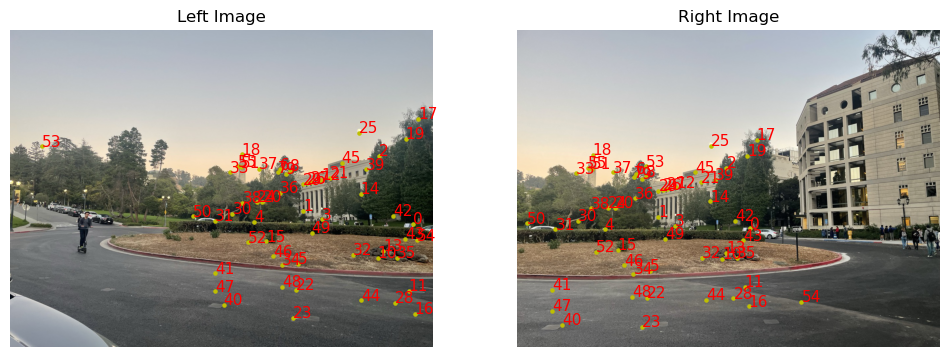

In [9]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

ax[0].imshow(image_left, cmap='gray')
ax[0].set_title('Left Image')
ax[1].imshow(image_right, cmap='gray')
ax[1].set_title('Right Image')

for idx, (i, j) in enumerate(matches):
    y1, x1 = suppressed_coords_left[:, i]
    y2, x2 = suppressed_coords_right[:, j]
    
    # plot the points on the image
    ax[0].scatter(x1, y1, c='y', s=5)
    ax[1].scatter(x2, y2, c='y', s=5)

    # Remove axis
    ax[0].axis('off')
    ax[1].axis('off')

    # number the points on both images
    ax[0].text(x1, y1, str(idx), fontsize=11, color='r')
    ax[1].text(x2, y2, str(idx), fontsize=11, color='r')

plt.show()

## 4-Point RANSAC

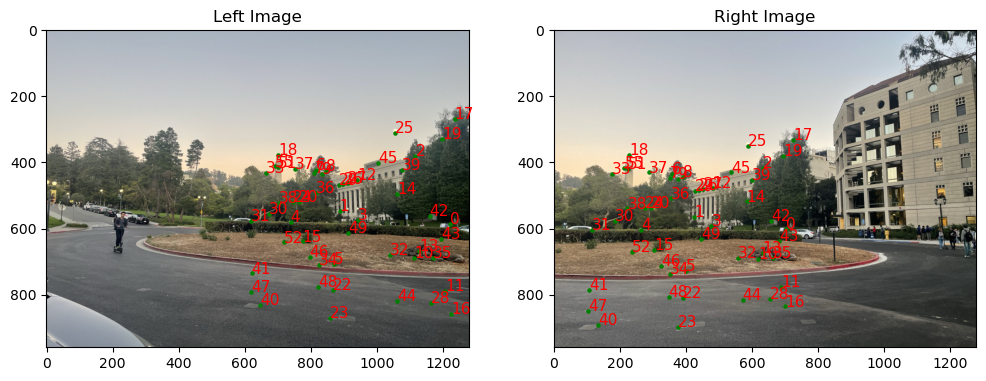

In [10]:
def computeH(im1_pts, im2_pts):
    num_pts = im1_pts.shape[0]
    A = []

    for i in range(num_pts):
        x1, y1 = im1_pts[i][0], im1_pts[i][1]
        x2, y2 = im2_pts[i][0], im2_pts[i][1]

        A.append([x1, y1, 1, 0, 0, 0, -x2 * x1, -x2 * y1, -x2])
        A.append([0, 0, 0, x1, y1, 1, -y2 * x1, -y2 * y1, -y2])

    A = np.array(A)
    _, _, V = np.linalg.svd(A)
    H = V[-1].reshape(3, 3)

    return H / H[-1, -1]

def warpPoints(points, H, min_x, min_y):
    num_points = points.shape[0]
    homogeneous_points = np.hstack([points, np.ones((num_points, 1))])

    warped_points = H @ homogeneous_points.T
    warped_points /= warped_points[2, :]

    warped_points[0, :] -= min_x
    warped_points[1, :] -= min_y

    return warped_points[:2, :].T

def apply_homography(H, points):
    num_pts = points.shape[0]
    points_homogeneous = np.hstack((points, np.ones((num_pts, 1))))
    transformed_points = (H @ points_homogeneous.T).T
    transformed_points /= transformed_points[:, 2][:, np.newaxis]
    return transformed_points[:, :2]

def ransac_homography(matches, coords_left, coords_right, num_iterations=1000, threshold=5):
    best_H = None
    max_inliers = 0
    best_inliers = []

    for _ in range(num_iterations):
        # Randomly select 4 matches
        sample_indices = np.random.choice(len(matches), 4, replace=False)
        sample_matches = [matches[i] for i in sample_indices]

        im1_pts = np.array([coords_left[:, i] for i, _ in sample_matches])
        im2_pts = np.array([coords_right[:, j] for _, j in sample_matches])

        # Compute homography
        H = computeH(im1_pts, im2_pts)

        # Apply homography to all points
        all_im1_pts = np.array([coords_left[:, i] for i, _ in matches])
        all_im2_pts = np.array([coords_right[:, j] for _, j in matches])
        transformed_pts = apply_homography(H, all_im1_pts)

        # Compute inliers
        distances = np.linalg.norm(transformed_pts - all_im2_pts, axis=1)
        inliers = distances < threshold
        num_inliers = np.sum(inliers)

        if num_inliers > max_inliers:
            max_inliers = num_inliers
            best_H = H
            best_inliers = inliers

    return best_H, best_inliers

best_H, best_inliers = ransac_homography(matches, suppressed_coords_left, suppressed_coords_right)

# Visualize inliers
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

ax[0].imshow(image_left, cmap='gray')
ax[0].set_title('Left Image')
ax[1].imshow(image_right, cmap='gray')
ax[1].set_title('Right Image')

for idx, (i, j) in enumerate(matches):
    if best_inliers[idx]:
        y1, x1 = suppressed_coords_left[:, i]
        y2, x2 = suppressed_coords_right[:, j]
        
        ax[0].scatter(x1, y1, c='g', s=5)
        ax[1].scatter(x2, y2, c='g', s=5)
        ax[0].text(x1, y1, str(idx), fontsize=11, color='r')
        ax[1].text(x2, y2, str(idx), fontsize=11, color='r')

plt.show()

In [15]:
# Extract the indices of the inliers from the matches
inlier_indices = [i for idx, (i, j) in enumerate(matches) if best_inliers[idx]]

# Get the corresponding coordinates from suppressed_coords_left and suppressed_coords_right
inlier_coords_left = suppressed_coords_left[:, inlier_indices]
inlier_coords_right = suppressed_coords_right[:, inlier_indices]

# Print the inlier coordinates
print("Inlier coordinates in left image:")
print(inlier_coords_left)

print("Inlier coordinates in right image:")
print(inlier_coords_right)

Inlier coordinates in left image:
[[ 587  548  380  573  580  707  422  431  426  435  689  790  454  669
   495  639  859  269  376  330  520  787  871  520  311  464  461  826
   467  556  578  681  431  711  689  492  420  522  422  832  736  562
   631  818  401  685  791  778  613  415  642  412]
 [1221  888 1117  943  739  871  816  811  847  835 1113 1207  941 1129
  1061  776 1225 1236  701 1198  764  866  857  746 1056  899  912 1164
   886  673  620 1039  665  824 1171  816  753  703 1076  646  621 1160
  1196 1062 1004  797  620  823  913  700  719  691]]
Inlier coordinates in right image:
[[ 351  417   64   85  603  880  913  412  560  262  201  218  489  464
    49  351  665  816  592  311  213  593  367  309  514  823  467  899
   138   94  396  565  737  692   32   79  382  773  233  664  105  882
   585  784   26  186   91  102  160  776  635  492]
 [1031 1035 1142 1169  264 1240  433  389 1026  376   79 1232  582 1247
   284   71  303  572 1102 1149  878 1106  763 1159

In [12]:
import scipy as sp

def warpImage(im, H):
    height, width = im.shape[:2]

    # Define corners of the original image in homogeneous coordinates
    corners = np.array([
        [0, 0, 1], [width - 1, 0, 1],
        [width - 1, height - 1, 1], [0, height - 1, 1]
    ]).T

    # Warp the corners using the homography matrix
    warped_corners = H @ corners
    warped_corners /= warped_corners[2, :]  # Normalize homogeneous coordinates

    # Calculate the bounding box for the warped image
    min_x = int(np.floor(min(warped_corners[0, :])))
    min_y = int(np.floor(min(warped_corners[1, :])))
    max_x = int(np.ceil(max(warped_corners[0, :])))
    max_y = int(np.ceil(max(warped_corners[1, :])))

    # Create a meshgrid for the output coordinates
    X, Y = np.meshgrid(np.arange(min_x, max_x), np.arange(min_y, max_y))
    warped_coords = np.vstack((X.ravel(), Y.ravel(), np.ones(X.size)))

    # Compute inverse homography to map to input image coordinates
    H_inv = np.linalg.inv(H)
    input_coords = H_inv @ warped_coords
    input_coords /= input_coords[2, :]  # Normalize homogeneous coordinates

    input_X = input_coords[0, :].reshape(max_y - min_y, max_x - min_x)
    input_Y = input_coords[1, :].reshape(max_y - min_y, max_x - min_x)

    # Interpolate pixel values for each channel
    warped_im = np.zeros((max_y - min_y, max_x - min_x, im.shape[2]), dtype=im.dtype)

    grid_x, grid_y = np.meshgrid(np.arange(width), np.arange(height))

    for channel in range(im.shape[2]):
        # interpolate using griddata
        values = im[..., channel].ravel()
        points = np.vstack((grid_x.ravel(), grid_y.ravel())).T

        warped_im[..., channel] = sp.interpolate.griddata(
            points,
            values,
            (input_X, input_Y),
            method='linear',
            fill_value=0
        ) 

    return warped_im, min_x, min_y

image_left_warped, min_x, min_y = warpImage(image_left, best_H)

In [16]:
warped_points = warpPoints(inlier_coords_left, best_H, min_x, min_y)

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 53 is different from 3)

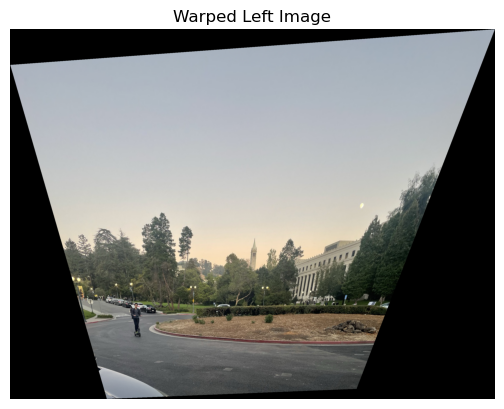

In [17]:
plt.imshow(image_left_warped)
plt.axis('off')
plt.title('Warped Left Image')
plt.show()

In [ ]:
def create_blending_mask(warped_left, panorama_right):
    mask_left = np.zeros(warped_left.shape[:2], dtype=np.uint8)
    mask_right = np.zeros(panorama_right.shape[:2], dtype=np.uint8)
    
    mask_left[np.sum(warped_left, axis=2) > 0] = 1
    mask_right[np.sum(panorama_right, axis=2) > 0] = 1

    # Compute the distance transform
    dtrans_left = distance_transform_edt(mask_left)
    dtrans_right = distance_transform_edt(mask_right)

    # Create an alpha mask
    alpha_mask = dtrans_left / (dtrans_left + dtrans_right + 1e-10)  # Avoid division by zero
    alpha_mask = np.clip(alpha_mask, 0, 1)  # Ensure the values are between 0 and 1
    
    return alpha_mask

def blend_images(warped_left, panorama_right, alpha_mask):
    alpha_mask = np.repeat(alpha_mask[:, :, np.newaxis], 3, axis=2)

    blended_image = warped_left * alpha_mask + panorama_right * (1 - alpha_mask)
    blended_image = blended_image.astype(np.uint8)
    
    return blended_image

def apply_affine_transform(image, transformation_matrix, output_shape):
    output_image = np.zeros((output_shape[0], output_shape[1], image.shape[2]), dtype=image.dtype)
    inverse_transform = np.linalg.inv(np.vstack([transformation_matrix, [0, 0, 1]]))[:2, :]
    
    # Iterate through each pixel in the output image
    for y in range(output_shape[0]):
        for x in range(output_shape[1]):
            source_coords = np.dot(inverse_transform, [x, y, 1])
            src_x, src_y = source_coords[0], source_coords[1]
            
            # Bilinear interpolation
            if 0 <= src_x < image.shape[1] and 0 <= src_y < image.shape[0]:
                x0, y0 = int(src_x), int(src_y)
                dx, dy = src_x - x0, src_y - y0
                
                # Ensure the coordinates are within bounds
                x1 = min(x0 + 1, image.shape[1] - 1)
                y1 = min(y0 + 1, image.shape[0] - 1)
                
                # Get the four neighboring pixel values
                pixel_00 = image[y0, x0]
                pixel_01 = image[y0, x1]
                pixel_10 = image[y1, x0]
                pixel_11 = image[y1, x1]
                
                # Perform bilinear interpolation
                output_image[y, x] = (
                    pixel_00 * (1 - dx) * (1 - dy) +
                    pixel_01 * dx * (1 - dy) +
                    pixel_10 * (1 - dx) * dy +
                    pixel_11 * dx * dy
                )

    return output_image

def align_and_blend_images_custom(im1, im2, warped_points, target_points):
    # Compute the rotation angle
    angle_warped = np.arctan2(warped_points[1, 1] - warped_points[0, 1], 
                               warped_points[1, 0] - warped_points[0, 0])
    angle_target = np.arctan2(target_points[1, 1] - target_points[0, 1], 
                              target_points[1, 0] - target_points[0, 0])
    
    rotation_angle = angle_target - angle_warped

    # Compute the translation
    translation_x = target_points[0, 0] - (
        np.cos(rotation_angle) * warped_points[0, 0] -
        np.sin(rotation_angle) * warped_points[0, 1]
    )
    translation_y = target_points[0, 1] - (
        np.sin(rotation_angle) * warped_points[0, 0] +
        np.cos(rotation_angle) * warped_points[0, 1]
    )

    # Build the affine transformation matrix
    transformation_matrix = np.array([
        [np.cos(rotation_angle), -np.sin(rotation_angle), translation_x],
        [np.sin(rotation_angle),  np.cos(rotation_angle), translation_y]
    ])

    height, width = im2.shape[:2]
    corners = np.array([
        [0, 0],
        [im1.shape[1], 0],
        [im1.shape[1], im1.shape[0]],
        [0, im1.shape[0]]
    ])
    transformed_corners = np.dot(np.c_[corners, np.ones(4)], transformation_matrix.T)[:, :2]

    min_x_transformed = min(transformed_corners[:, 0])
    max_x_transformed = max(transformed_corners[:, 0])
    min_y_transformed = min(transformed_corners[:, 1])
    max_y_transformed = max(transformed_corners[:, 1])

    # Size of the canvas
    canvas_width = int(max(max_x_transformed, width) - min(min_x_transformed, 0))
    canvas_height = int(max(max_y_transformed, height) - min(min_y_transformed, 0))

    # Overlay the aligned image over im2
    result_image = np.zeros((canvas_height, canvas_width, 3), dtype=np.uint8)
    offset_x = int(-min(min_x_transformed, 0))
    offset_y = int(-min(min_y_transformed, 0))
    result_image[offset_y:offset_y + height, offset_x:offset_x + width] = im2  # Add the base image

    translation_x_centered = translation_x + offset_x
    translation_y_centered = translation_y + offset_y

    # Update the transformation matrix with the centered translation
    transformation_matrix_centered = np.array([
        [np.cos(rotation_angle), -np.sin(rotation_angle), translation_x_centered],
        [np.sin(rotation_angle),  np.cos(rotation_angle), translation_y_centered]
    ])

    # Affine Transformation
    aligned_image_centered = apply_affine_transform(im1, transformation_matrix_centered, (canvas_height, canvas_width))

    # Create the blending mask using the aligned images
    alpha_mask = create_blending_mask(aligned_image_centered, result_image)

    # Visualize the alpha mask
    plt.figure(figsize=(10, 7))
    plt.imshow(alpha_mask, cmap='gray')
    plt.title('Alpha Mask')
    plt.axis('off')
    plt.show()

    # Blend the images using the generated alpha mask
    blended_image = blend_images(aligned_image_centered, result_image, alpha_mask)

    return blended_image

In [ ]:
# Align and blend the images
result_image = align_and_blend_images_custom(warped_left, image_right, warped_points, suppressed_coords_right)

# Display the result
plt.figure(figsize=(10, 7))
plt.imshow(result_image)
plt.title('Aligned and Blended Image')
plt.axis('off')
plt.show()